# Configuration initiale

In [62]:
# Imports utiles :
!pip install transformers
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
import tensorflow as tf
import numpy as np
import pandas as pd

In [63]:
# Spécifique à l'exécution sur Google Colab : pour accéder à l'ensemble des fichiers et répertoires utiles
from google.colab import drive
drive.mount('/drive')
%cd /drive/MyDrive/data/pipotron/
%pwd
%ls -al

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive/MyDrive/data/pipotron
total 63
drwx------ 2 root root  4096 Mar 18 09:34 donnees/
drwx------ 2 root root  4096 Mar 16 10:40 .git/
-rw------- 1 root root  1819 Mar 16 11:10 .gitignore
-rw------- 1 root root  3849 Mar 17 11:25 git.ipynb
drwx------ 3 root root  4096 Mar 16 10:46 models/
-rw------- 1 root root 45471 Mar 18 10:12 pipotron_entrainement.ipynb
-rw------- 1 root root    79 Mar 16 10:40 README.md


In [64]:
# Configuration du tokenizer :

# On va s'appuyer sur un modèle de générateur GPT-2 (merci OpenAI) pré-entraîné sur la langue française (merci Antoine Louis),
# et on utilise la bibliothèque transformers (merci à HuggingFace):
model_name = "antoiloui/belgpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
nb_added_tokens = 0

# On ajoute au tokenizer des tokens de "déclenchement" (en début de séquence, pour indiquer que ce qui suit est un commentaire de vin) et de padding
L_first_tokens = ["<|review|>"]  # Tokens de déclenchement : on pourrait en avoir plusieurs (ex: <|vinrouge|>, <|vinblanc|>...)
nb_added_tokens += tokenizer.add_special_tokens({'pad_token': "<|pad|>", 'eos_token':"<|end|>"})
if len(L_first_tokens)>0:
    nb_added_tokens += tokenizer.add_special_tokens({'additional_special_tokens': L_first_tokens})
print(nb_added_tokens, "token(s) ajoutés")

# On vérifie la bonne définition des tokens de padding et de fin de séquence :
print(tokenizer.pad_token, ":", tokenizer.pad_token_id)
assert tokenizer.pad_token_id!=None
print(tokenizer.eos_token, ":", tokenizer.eos_token_id)
assert tokenizer.eos_token_id!=None

3 token(s) ajoutés
<|pad|> : 50257
<|end|> : 50258


# Entraînement du modèle

In [65]:
# Chargement des données disponibles :

from_full_table = False  # Je ne mets pas les données complètes (non publiques) sur le GitHub, seulement l'extraction utile ici
reviews_filename = "donnees/review_only.txt"

if from_full_table:
  # Chargement du fichier complet, issu du scraping du site larvf.com (données accessibles par abonnement, non publiques):
  DF_rvf = pd.read_csv("/drive/MyDrive/donnees/larvf_2020-11-24.csv")
  print("Nombre de revues textuelles disponibles :", len(DF_rvf)-DF_rvf['review_text'].isna().sum())

  # On sélectionne la colonne qui nous intéresse en retirant les valeurs manquantes, et on fait un mélange aléatoire: 
  S_reviews = DF_rvf['review_text'][~DF_rvf['review_text'].isna()].sample(frac=1, random_state=57840).reset_index(drop=True)
  S_reviews = S_reviews.drop_duplicates()
  print("Nombre de revues textuelles après suppression des doublons :", len(S_reviews))
  display(list(S_reviews.head(4)))
  
  # On enregistre ces données pour ce projet:
  S_reviews.to_csv(reviews_filename, header=False, index=False)

else:
  S_reviews = pd.read_csv(reviews_filename, header=None).iloc[:, 0]
  print("Nombre de revues :", len(S_reviews))
  display(list(S_reviews.head(4)))


Nombre de revues : 30208


['Salivant, énergique et élancé sur des langoustines, du homard ou des rougets. Un magnifique 2012 qui se prête à cet exercice.',
 'Plus en finesse, 1769 Sciaccarellu offre plus de volume et de fraîcheur, avec des tanins friands et épicés en finale.',
 'Vin puissant, viril, marqué par le caractère végétal de la vendange en grappes entières, mais avec un fruit pur et persistant. Le tout doit s’harmoniser, mais ce mazis s’imposera comme référent.',
 'jus équilibré et vif, bien en place.']

In [67]:
# Préparation des données:
import re

# On ajoute un nouveau mot (token) qui a vocation à servir de déclencheur pour générer un nouveau commentaire de dégustation.
# On supprime également les informations de date du commentaire, parfois présentes.
# Enfin on ajoute un token de fin de séquence pour inciter le modèle à produire des commentaires de taille raisonnable.
L_reviews = [L_first_tokens[0] + " " + re.sub(r"\([^\(\)]*\.[0-9][0-9][0-9][0-9]\)", "", review.strip()) for review in list(S_reviews)]
L_reviews = [re.sub(r"[0-9]*\s?\%", "", review) for review in L_reviews] # On supprime les pourcentages car notre générateur n'est pas bon en calcul...
L_reviews = [re.sub("\(\)", "", review) for review in L_reviews]  # Suppression des parenthèses inutiles
L_reviews = [re.sub(r"\s+", " ", review.strip()) + " <|end|>" for review in L_reviews]  # Suppression des espaces inutiles et ajout du token de fin

# Affichons le résultat de cette préparation sur quelques lignes:
for i in range(0,10):
  print(L_reviews[np.random.randint(0, len(L_reviews))])

<|review|> Il se démarque par une texture d’un beau raffinement et un nez épicé et délicat. La bouche le confirme : matière délicate, fruit net et précis. <|end|>
<|review|> Un nez discret, une bouche souple et tendre. Si l’on aime son fruit épuré et la finesse de son lieu de naissance qu’il retranscrit superbement, il manque un rien de densité en bouche pour un premier cru de ce calibre. <|end|>
<|review|> Belle expression de chardonnay à maturité, frais, minéral. L'élevage boisé accompagne sans marquer ce modèle de saint-véran. <|end|>
<|review|> Nez somptueux de vendange entière. Encore en cuves, il livre une matière pleine, mais avec une belle qualité de tanins. Sans perdre en volume ni en relief, les vins de ce domaine progressent en harmonie grâce à un travail d’extraction plus sensible. <|end|>
<|review|> Plus confite, plus ample et plus épicée que la Sélection des Terrasses du même domaine, cette cuvée offre un équilibre liquoreux, une matière très profonde, une réelle vivacité

In [68]:
# On vérifie le nombre de lignes:
print(len(L_reviews))

30208


In [69]:
# On charge le modèle de "transfer learning" et on le prépare à recevoir nos nouveaux tokens:
model = TFGPT2LMHeadModel.from_pretrained(model_name)
_ = model.resize_token_embeddings(tokenizer.vocab_size + nb_added_tokens)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at antoiloui/belgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [72]:
# On vérifie qu'un commentaire de vin est inchangé après tokenisation puis détokenisation:
i = np.random.randint(0, len(L_reviews))
print(L_reviews[i])
print(tokenizer.decode(tokenizer.encode(L_reviews[i])))
assert L_reviews[i] == tokenizer.decode(tokenizer.encode(L_reviews[i]))

<|review|> La Chapelle 2017 joue la carte de la très belle fraîcheur, avec une bouche ample, mais aussi très digeste et sapide <|end|>
<|review|> La Chapelle 2017 joue la carte de la très belle fraîcheur, avec une bouche ample, mais aussi très digeste et sapide <|end|>


Nombre maximal de tokens retenu (seuil) : 63.0
Nombre de revues conservées : 27341


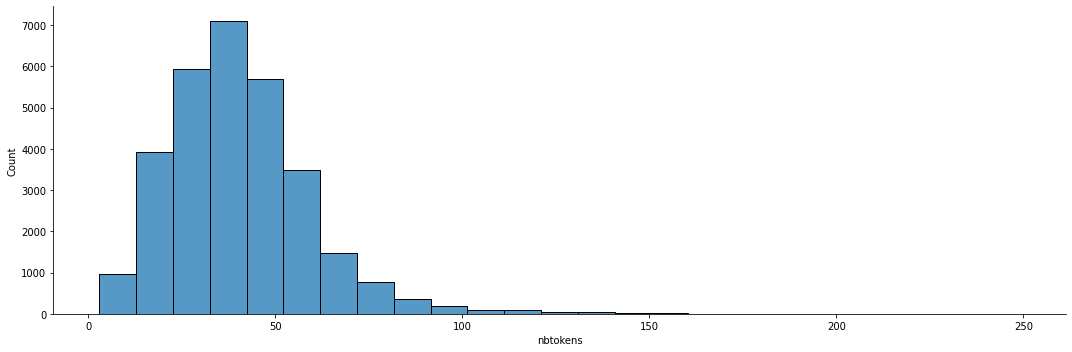

In [75]:
# Pour limiter les calculs inutiles et le besoin de padding, on ne va garder que 90% des revues, celles ayant le plus faible nombre de tokens.
# (Pareto est notre ami :-))

import seaborn as sns
unpadded = tokenizer(L_reviews, padding=False)
L_nbtokens = [len(t) for t in unpadded.input_ids]
DF_nbtokens = pd.DataFrame(pd.Series(L_nbtokens, name='nbtokens'))
sns.displot(kind='hist', data=DF_nbtokens, x='nbtokens', bins=25, aspect=3)
threshold = DF_nbtokens.nbtokens.quantile(0.9)
print("Nombre maximal de tokens retenu (seuil) :", threshold)

L_short_reviews = [L_reviews[i] for i in range(0, len(L_reviews)) if L_nbtokens[i]<=threshold]
print("Nombre de revues conservées :", len(L_short_reviews))

In [76]:
# On prépare les données d'entraînement du générateur:
# Le générateur prédit le mot suivant pour chaque mot (ou plutôt token, en l'occurrence wordpiece) du texte fourni en entrée.
# Donc l'ensemble d'apprentissage est constitué de tuples (x=entrée, y=sortie) où y est un décalage de x d'un token vers la droite.
# On prévoit aussi un ensemble de test afin de pouvoir évaluer le surapprentissage.

batch_size = 16
train_size = int(0.80*len(L_short_reviews)/batch_size)*batch_size
print("Taille des batches :", batch_size)
print("Nombre de lignes dans la base d'apprentissage :", train_size)

encodings = tokenizer(L_short_reviews, padding=True, return_tensors='tf')
input_ids = encodings.input_ids
attention_mask = encodings.attention_mask
x = {'input_ids': input_ids[:, :-1], 'attention_mask': attention_mask[:, :-1]}
y = input_ids[:, 1:]
assert x['input_ids'].shape == y.shape
assert x['attention_mask'].shape == y.shape
full_dataset = tf.data.Dataset.from_tensor_slices((x, y))
train_dataset = full_dataset.take(train_size).batch(batch_size).repeat()
test_dataset = full_dataset.skip(train_size).batch(batch_size)

Taille des batches : 16
Nombre de lignes dans la base d'apprentissage : 21872


In [77]:
# On "encapsule" le modèle initial dans un modèle qui ne renvoie que les "logit" des probabilités des mots,
# ce à quoi on peut appliquer la fonction de coût classique (entropie croisée)

class Pipotron(tf.keras.Model):
  def __init__(self, model):
    super().__init__(name="Pipotron")
    self.gpt2 = model
  def __call__(self, input, training=False):    
    y = self.gpt2(input, training=training)
    return y.logits

pipotron = Pipotron(model)

In [78]:
# On contrôle les formats d'entrée et de sortie du modèle (à ce stade il est déboussolé par notre token de déclenchement):
for features, labels in train_dataset.take(1):
  i=4
  for k in features.keys():
    print(k, ":", features[k].shape)
  print(tokenizer.decode(features['input_ids'][i], skip_special_tokens=False))
  print("labels :", labels.shape)
  print(tokenizer.decode(labels[i], skip_special_tokens=False))
  z = pipotron(features)
  print("output :", z.shape)


input_ids : (16, 62)
attention_mask : (16, 62)
<|review|> Un vin campé sur son élevage, avec un fruit fin, mais aussi une acidité élevée. L’ensemble est prometteur, mais pas encore en place. <|end|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>
labels : (16, 62)
Un vin campé sur son élevage, avec un fruit fin, mais aussi une acidité élevée. L’ensemble est prometteur, mais pas encore en place. <|end|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>
output : (16, 62, 50260)


In [79]:
# Paramétrage de l'entraînement :

# TO DO : idéalement, appliquer un learning_rate dégressif (scheduler)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
pipotron.compile(optimizer=optimizer, loss=loss)

In [ ]:
# ENTRAINEMENT (fine tuning) DU MODELE :

# Pour bien voir la progression, on affiche le score à chaque 'round' (pseudo-epoch, qui est en fait une subdivision de la 'vraie'
# epoch qui consisterait à passer toute la base d'entraînement une seule fois):
nb_epochs = 8
nb_steps_per_round = 400
nb_rounds = (nb_epochs*len(L_short_reviews))//(batch_size*nb_steps_per_round)
print("Nombre d'étapes (rounds) d'entraînement prévues :", nb_rounds)
H_history = pipotron.fit(train_dataset, validation_data=test_dataset, epochs=nb_rounds, steps_per_epoch=nb_steps_per_round)

Nombre d'étapes (rounds) d'entraînement prévues : 34
Epoch 1/34
400/400 [==============================] - 154s 356ms/step - loss: 2.5077 - val_loss: 1.8599
Epoch 2/34
 79/400 [====>.........................] - ETA: 1:31 - loss: 1.7813

In [ ]:
"""
// Pour maintenir le Notebook connecté, utiliser si besoin (et adapter si besoin selon évolutions de Colab...)
// le code Javascript suivant (Ctrl+Shift+I, Console):
function ClickConnect4(){
    console.log("Clicked on menu"); 
    document.querySelector("div.goog-inline-block.goog-menu-button-caption").click()
}
ClickConnect4()
setInterval(ClickConnect4,60000)
"""

In [ ]:
# Sauvegarde du modèle:
import time

fullpath = "models/pipotron_" + str(int(time.time()/60))
model.save_pretrained(fullpath)
print("MODEL SAVED AT :", fullpath)

MODEL SAVED AT : models/pipotron_26932982


# Chargement du modèle (pipotron) déjà entraîné

In [32]:
# Rechargement du modèle, si besoin :

fullpath = "models/pipotron_26932982"
model = TFGPT2LMHeadModel.from_pretrained(fullpath)
pipotron = Pipotron(model)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at models/pipotron_26932982.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


# Utilisation et test du pipotron

In [41]:
# On affiche quelques commentaires générés par le modèle entraîné:

# TO DO: optimiser si besoin les paramètres de sampling (top_k, top_p, repetition_penalty, voire temperature)
# cf. par exemple https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277

def pipote(min_length=10, max_length=200, skip_special_tokens=True):
  input = tokenizer.encode(L_first_tokens[0], return_tensors='tf')
  output = model.generate(
      input_ids=input,
      min_length=min_length,
      max_length=max_length,
      do_sample=True,
      pad_token_id=tokenizer.pad_token_id,
      eos_token_id=tokenizer.eos_token_id,
      top_k=50,
      top_p=1,  # 1 = pas de sélection liée au total des probabilités estimées
      repetition_penalty=1.3
  )
  review = tokenizer.decode(output[0], skip_special_tokens=skip_special_tokens)
  review = re.sub(r"\s+", " ", review)
  return review

nb_comments = 8
for i in range(0, nb_comments):
  print(pipote())

# On constate que le modèle se débrouille bien en français, mais qu'il n'est pas très fort en ampélographie, en géographie et en mathématiques...

Un nez discret et une bouche en demi-puissance, manquant à 2 ou 3 des 4 NC du raisin.
En conversion bio, ce fleurie fait penser à une syrah plantée sur un coteau argilo-calcaire. Il donne ainsi l'impression de croquer dans du raisin frais : son énergie revigorante lui va comme gant!
Une robe intense, un fruit qui demeure juteux, le boisé est à sa place
Spontané, doté d'un côté salin et aiguisé, le vosne Les Plantes recèle de jolis amers : vigoureux, harmonieux, c'est un vin à l'allonge magistrale.
Une bouteille de facture classique, assez fine. La matière est bien tenue par une trame tannique qui amène du relief. On peut attendre un peu plus d’allonge et plus de droiture en finale, mais très prometteur.
Cette cuvée se montre riche, mais avec une bouche équilibrée. Une bouteille de caractère pour bien des plats sucrés ou semi-mûris.
Un nez qui sent les fruits noirs à l'eau-de-vie. Un beau vin frais avec une bouche nette, fraîche et élancée, qui exprime un bel équilibre entre maturité du

In [48]:
# Quelques vérifications que le modèle ne reproduit pas trop à l'identique les commentaires de la base d'apprentissage :

def cherche(s):
  L_found = [r for r in L_short_reviews if s in r]
  print()
  print(f"Nombre d'occurrences de \"{s}\" :", len(L_found))
  for found in L_found:
    print(found)

# Ex 1 : le modèle a proposé "à savourer dans les deux ans", alors que la base initiale ne connaît que "à savourer dans les trois ans" ou "dans sa jeunesse":
cherche("à savourer dans")

# Ex 2 : le "fruit plein et croquant" est une innovation de notre modèle
cherche("fruit plein et croquant")

# Ex 3 : "à la fois énergique et fin" est une innovation de notre modèle
cherche("à la fois énergique")

# Ex 4 : le "nez sur le fruit rouge" est une innovation de notre modèle
cherche("nez sur le fruit rouge")

# Ex 5 : "recèle de jolis amers" est une innovation de notre modèle
cherche("recèle de jolis")



Nombre d'occurrences de "à savourer dans" : 3
<|review|> Au nez, ce santenay embaume la cerise juteuse, bien mûre. De longueur moyenne, ce vin gourmand est à savourer dans sa jeunesse, sur son fruit. <|end|>
<|review|> Nez séduisant, belle générosité, notes de miel, fleurs et fruits jaunes. On retrouve ce beau volume en bouche, charnue, avec une puissance domptée par l’acidité qui le porte. Une belle cuvée ambitieuse et très maîtrisée à savourer dans les trois ans. <|end|>
<|review|> Savoureux et plein, avec un fruit qui demeure expressif et un très beau volume en bouche. C’est un vin de plaisir à savourer dans les trois ans. <|end|>

Nombre d'occurrences de "fruit plein et croquant" : 0

Nombre d'occurrences de "à la fois énergique" : 1
<|review|> La cuvée signe parfaitement le style de la maison. Ce Clavoillon est à la fois énergique, dense et sapide en finale. De l'éclat en bouche, sans artifices. <|end|>

Nombre d'occurrences de "nez sur le fruit rouge" : 0

Nombre d'occurrences d